In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator
from random import randrange, uniform
from CountNN import *
from HDF5 import *
from DFLSheet import *
from DFLSheet import DFLSheet
from DFLSheet import DFLSheetDataSet
from FireflyAlgorithm import *
import gc
import warnings
warnings.filterwarnings("ignore")

import pickle

C:\Users\Ky\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Model

In [2]:
period = 'shell'

if period == 'fresh':
    dataname = "DataSet_fresh_ws19_scale5_4fold_best"
    nn_option = pickle.load(open(dataname +'/param.pkl', 'rb'))
    nn_option['list_train'] = ['F4','F12','F16']
    nn_option['list_dfl'] = ['NT_F1','NT_F2','NT_F3']#,'F1','F5','F6','F13','F14','F15']
    nn_option['path_dfl'] = 'F\\'
    nn_option['best_thr'] = [0.,0.5]

elif period == 'allblue':
    dataname = "DataSet_allblue_ws19_scale5_4fold_best"
    nn_option = pickle.load(open(dataname +'/param.pkl', 'rb'))
    nn_option['list_train'] = ['A4','F7s','F10s']
    #nn_option['list_dfl'] = ['F3p','F8s','F9s','F11s']
    nn_option['list_dfl'] = ['CM_A4','CM_A5']
    nn_option['path_dfl'] = 'A\\'
    nn_option['best_thr'] = [0.,0.5,0.5]

elif period == 'shell':
    dataname = "DataSet_shell_ws19_scale5_4fold"
    nn_option = pickle.load(open(dataname +'/param.pkl', 'rb'))
    nn_option['list_train'] = ['S23a','S36s','S4','S33s']
    """
    nn_option['list_dfl'] = ['S2','S5','S6','S8','S9','S10','S11p','S12',
                             'S13p','S14a','S15a','S16a','S17a','S18a',
                             'S19a','S20a','S21a','S22a','S24a','S25a',
                             'S26a','S27a','S28a','S29a','S30a','S31p','S35s']
    """
    nn_option['list_dfl'] = ['CM_S1','SB_S1','SB_S2','SB_S3','SB_S4','SB_S5','SB_S6','SB_S7']
    nn_option['path_dfl'] = 'S\\'
    nn_option['best_thr'] = [0.,0.5,0.5,0.5]



In [3]:
empty_population = {
        'position': None,
        'cost': None,
        'best_position': None,
        'best_cost': None,
};
input_dim = nn_option['window_size']*nn_option['window_size']*nn_option['channels']

empty_result = {
        'cR_train': None,
        'cR_val': None,
        'cR_blind': None,
        'acc_train': None,
        'acc_val':None,
        'acc_blind': None,
        '#hidden': None,
        '#fold':None,}

In [4]:
empty_CR = {
        '#hidden': None,
        'best_fold':None,
        'avg_train': None,
        'sd_train': None,
        'best_val': None,
        'avg_val': None,
        'sd_val': None,
        'best_blind': None,}

In [5]:
from HDF5 import *
#best2 = Result.iloc[Result['cR_val'].argmax()]
f = 1
n_fold = f
dataname_fold = dataname+"/fold"+str(f)
X, Y, xX_test, xy_test = load_signature_lib(dataname,nn_option)

X_train, y_train,X_val, y_val = load_signature_lib_cv(dataname_fold,f)

  Unnamed: 0  background   shell  unfer   dead
0       S23a      3477.0  8378.0  579.0  357.0
1       S36s      3258.0  1291.0  420.0  506.0
2         S4      3083.0  1424.0   86.0  681.0
   Unnamed: 0  background   shell  unfer    dead
0  Traing set      2997.0   747.0  307.0   372.0
1   Blind set      6818.0  7965.0  775.0  1169.0
A Signature Library for  shell  period already exist
Dowloading completed....


In [6]:
X_train.shape

(3316, 19, 19, 3)

In [7]:
def power(image):
    image = image.astype('float')
    # Normalize images for better comparison.
    #image = (image - image.mean()) / image.std()
    image = image /255

    #print(np.real(image))
   #print(np.imag(image))
    #print(image)
    return image

def power2(image):
    image = image.astype('float')
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(np.real(image)**2 +
                   np.imag(image)**2)
    
   



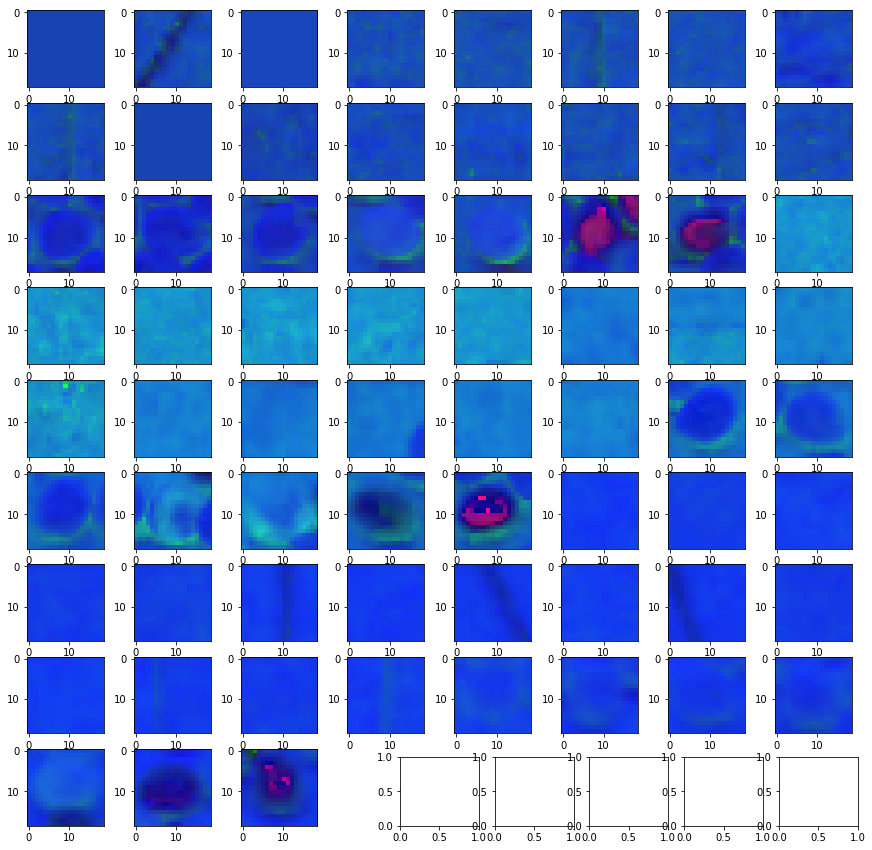

In [8]:
j = 1
row = 9
col = 8
plt.subplots(nrows=row+1, ncols=col+1, figsize=(15, 15))
for i in range(1,X_train.shape[0],50):
    plt.subplot(row,col,j)
    j = j+1
    plt.imshow((power(X_train[i,:,:,:])*255).astype('int'))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

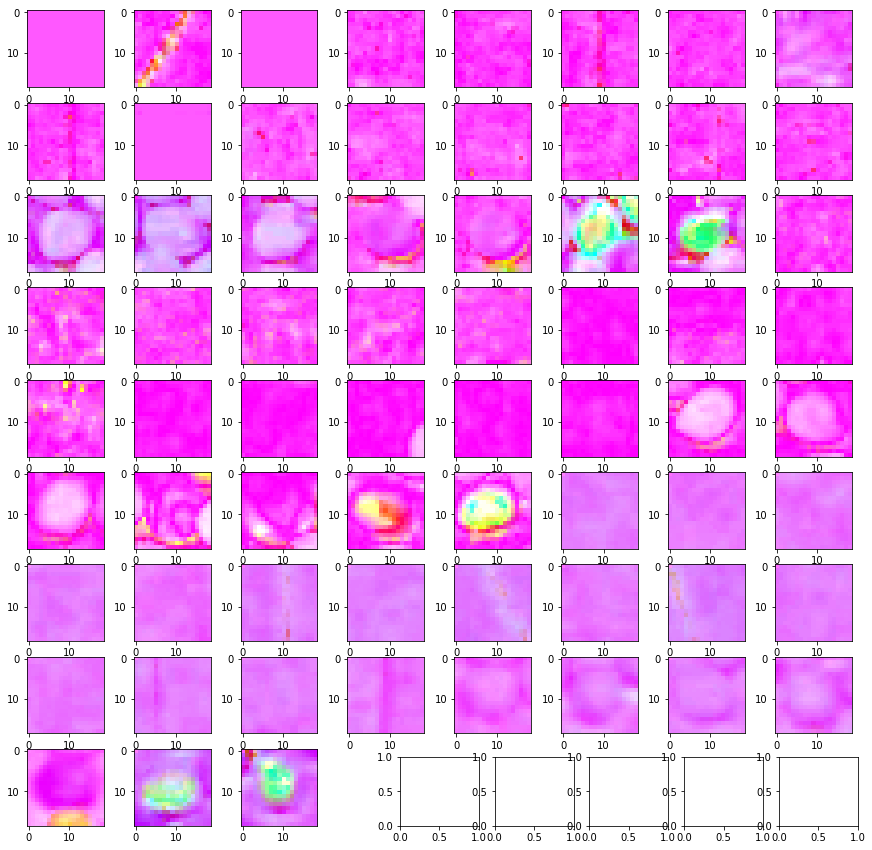

[[[  1  56 158]
  [ 26  60  89]
  [ 19  75  37]
  ...
  [ 23  75 197]
  [ 24  78 199]
  [ 23  80 204]]

 [[ 27  59 168]
  [ 26  63 108]
  [ 21  74  62]
  ...
  [ 22  69 190]
  [ 22  75 186]
  [ 23  78 185]]

 [[ 28  69 166]
  [ 25  70 138]
  [ 25  61 112]
  ...
  [ 21  59 194]
  [ 21  62 188]
  [ 21  65 180]]

 ...

 [[ 21  56 233]
  [ 19  53 232]
  [ 20  52 229]
  ...
  [ 18  53 220]
  [ 18  57 222]
  [ 19  57 225]]

 [[ 22  64 222]
  [ 21  58 232]
  [ 20  56 232]
  ...
  [ 18  54 229]
  [ 18  56 227]
  [ 19  57 231]]

 [[ 23  68 216]
  [ 22  67 219]
  [ 22  63 229]
  ...
  [ 18  55 230]
  [ 18  54 233]
  [ 19  56 235]]]
[[[1.12620219 0.36328855 1.05156948]
  [0.77942327 0.30780392 0.09445963]
  [0.87652137 0.09973657 0.62684054]
  ...
  [0.82103674 0.09973657 1.59254461]
  [0.80716558 0.05812309 1.62028692]
  [0.82103674 0.03038078 1.68964271]]

 [[0.76555211 0.32167508 1.19028105]
  [0.77942327 0.26619045 0.35801162]
  [0.84877905 0.11360772 0.28006161]
  ...
  [0.83490789 0.1829635

In [9]:
j = 1
plt.subplots(nrows=row+1, ncols=col+1, figsize=(15, 15))
for i in range(1,X_train.shape[0],50):
    plt.subplot(row,col,j)
    j = j+1
    plt.imshow((power2(X_train[i,:,:,:])*255).astype('int'))
plt.show()

print((power(X_train[i,:,:,:])*255).astype('int'))
print((power2(X_train[i,:,:,:])))

In [ ]:
print((power(X_train[i,:,:,:])))